In [37]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import random
import time
from itertools import product

# Initial Setup

In [38]:
# Load data
df = pd.read_csv('titik_semprotan.csv')
ids = df['id'].tolist()
locations = df[['x', 'y']].values

# --- 0) Caching jarak antar titik (tetap boleh dipakai on-demand) ---
distance_cache = {}

# id -> index ke array locations (diasumsikan locations selaras dengan ids)
id2idx = {i: k for k, i in enumerate(ids)}

def get_weight(i, j):
    key = (i, j)
    if key in distance_cache:
        return distance_cache[key]
    ii, jj = id2idx[i], id2idx[j]
    dx = locations[ii][0] - locations[jj][0]
    dy = locations[ii][1] - locations[jj][1]
    d = float(np.hypot(dx, dy))
    distance_cache[(i, j)] = d
    distance_cache[(j, i)] = d
    return d

# --- 1) Nodes deterministik (order-preserving unique), bukan set(ids) ---
nodes = list(dict.fromkeys(ids))     # menjaga urutan, menghilangkan duplikat
N = len(nodes)

# mapping ID -> index baris/kolom di D
idx = {node: k for k, node in enumerate(nodes)}

# --- 2) Bangun matrix koordinat sesuai urutan nodes ---
coords = np.empty((N, 2), dtype=np.float64)
for k, node in enumerate(nodes):
    ii = id2idx[node]
    coords[k, 0] = locations[ii][0]
    coords[k, 1] = locations[ii][1]

# --- 3) Vectorized distance matrix (cepat & konsisten) ---
diff = coords[:, None, :] - coords[None, :, :]     # shape (N, N, 2)
D = np.sqrt((diff * diff).sum(axis=2))              # shape (N, N), float64
np.fill_diagonal(D, 0.0)                            # diagonal nol

# Opsional: pakai matrix D + idx (lebih cepat, no cache lookup)
def total_distance(tour):
    L = len(tour)
    if L < 2:
        return 0.0
    s = 0.0
    for i in range(L - 1):
        s += D[idx[tour[i]], idx[tour[i+1]]]
    s += D[idx[tour[-1]], idx[tour[0]]]
    return float(s)

def split_ids(ids, num_vehicles):
    ids_copy = ids[:]
    random.shuffle(ids_copy)
    return [ids_copy[i::num_vehicles] for i in range(num_vehicles)]

# K Clustering

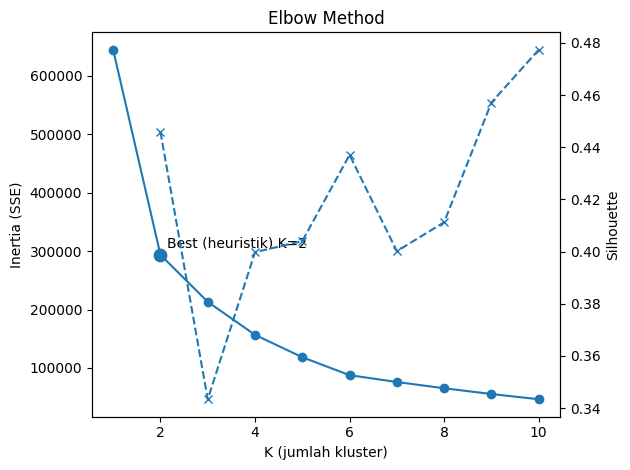

K kandidat: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Heuristik best K: 2
Jumlah kluster: 2
Cluster 0: 75 titik
Cluster 1: 60 titik


In [39]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def elbow_analysis(coords, k_min=1, k_max=10, random_state=42, n_init=10, show_plot=True):
    k_values = list(range(k_min, min(k_max, len(coords)) + 1))
    inertias = []
    silhouettes = []

    for k in k_values:
        km = KMeans(n_clusters=k, n_init=n_init, random_state=random_state)
        km.fit(coords)
        inertias.append(km.inertia_)
        if k >= 2:
            sil = silhouette_score(coords, km.labels_)
            silhouettes.append(sil)
        else:
            silhouettes.append(np.nan)

    # Heuristik "knee" sederhana: cari K yang memaksimalkan penurunan relatif inertia
    # (bukan metode resmi kneedle, tapi praktis untuk start)
    best_k = k_values[0]
    if len(k_values) >= 3:
        drops = []
        for i in range(1, len(inertias)):
            drop = (inertias[i-1] - inertias[i]) / max(inertias[i-1], 1e-9)
            drops.append(drop)
        # Pilih K setelah penurunan terbesar (i index drop untuk transisi k_values[i-1] -> k_values[i])
        best_k = k_values[np.argmax(drops) + 1]

    if show_plot:
        fig, ax1 = plt.subplots()
        ax1.plot(k_values, inertias, marker='o')
        ax1.set_xlabel('K (jumlah kluster)')
        ax1.set_ylabel('Inertia (SSE)')
        ax1.set_title('Elbow Method')
        # Tandai best_k jika masuk dalam range
        if best_k in k_values:
            ybk = inertias[k_values.index(best_k)]
            ax1.scatter([best_k], [ybk], s=80)
            ax1.annotate(f'Best (heuristik) K={best_k}', (best_k, ybk), xytext=(5, 5), textcoords='offset points')

        # Plot silhouette di sumbu kedua (opsional)
        ax2 = ax1.twinx()
        ax2.plot(k_values, silhouettes, marker='x', linestyle='--')
        ax2.set_ylabel('Silhouette')

        plt.tight_layout()
        plt.show()

    return {
        "k_values": k_values,
        "inertias": inertias,
        "silhouettes": silhouettes,
        "best_k_heuristic": best_k
    }

def run_kmeans(coords, nodes, k, random_state=42, n_init=10):
    if k < 1 or k > len(coords):
        raise ValueError("k harus di antara 1 dan jumlah titik.")
    km = KMeans(n_clusters=k, n_init=n_init, random_state=random_state)
    labels = km.fit_predict(coords)
    centroids = km.cluster_centers_

    clusters = {c: [] for c in range(k)}
    for node, lab in zip(nodes, labels):
        clusters[int(lab)].append(node)

    return labels, clusters, centroids

# === Contoh pemakaian cepat ===
# 1) Cari K yang masuk akal
info = elbow_analysis(coords, k_min=1, k_max=10, random_state=0, n_init=20, show_plot=True)
print("K kandidat:", info["k_values"])
print("Heuristik best K:", info["best_k_heuristic"])

# 2) Pilih K (misal dari heuristik atau manual), lalu cluster
chosen_k = info["best_k_heuristic"]
labels, clusters, centroids = run_kmeans(coords, nodes, chosen_k)
print("Jumlah kluster:", chosen_k)
for c, ids_in_c in clusters.items():
    print(f"Cluster {c}: {len(ids_in_c)} titik")

# === (Opsional) Visualisasi kluster ===
def plot_clusters(coords, labels, centroids=None):
    """
    Scatter plot titik dengan pewarnaan per kluster.
    """
    labels = np.asarray(labels)
    k = int(labels.max()) + 1
    for c in range(k):
        pts = coords[labels == c]
        plt.scatter(pts[:,0], pts[:,1], label=f'Cluster {c}', s=20)
    if centroids is not None:
        plt.scatter(centroids[:,0], centroids[:,1], marker='^', s=120)
    plt.legend()
    plt.title('K-Means Clusters')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.tight_layout()
    plt.show()

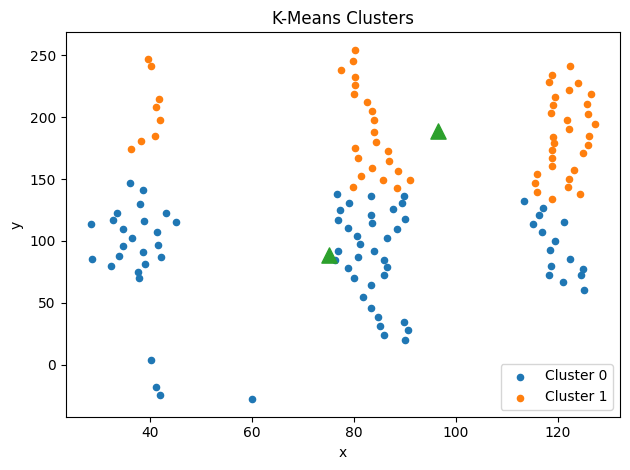

In [40]:
plot_clusters(coords, labels, centroids)

# Ortools for Benchmarking

In [41]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

SCALE = 1000  # presisi jarak

def _build_distance_matrix(nodes, use_D=True, scale=SCALE):
    N = len(nodes)
    if use_D:
        return [[int(round(scale * float(D[idx[nodes[i]], idx[nodes[j]]])))
                 for j in range(N)] for i in range(N)]
    else:
        return [[int(round(scale * get_weight(nodes[i], nodes[j])))
                 for j in range(N)] for i in range(N)]

def _remap_labels_to_vehicles(labels, starts_ids):
    """
    Pastikan indeks kendaraan 0..K-1 konsisten dengan urutan starts_ids.
    Kita buat mapping label_kluster -> vehicle_id berdasarkan label titik start tiap vehicle.
    """
    unique_from_starts = []
    for sid in starts_ids:
        unique_from_starts.append(labels[nodes.index(sid)])
    lbl_to_vid = {lbl: vid for vid, lbl in enumerate(unique_from_starts)}
    remapped = [lbl_to_vid[lbl] for lbl in labels]
    return remapped, lbl_to_vid

def create_data_model_clustered_custom(nodes, labels, starts_ids, ends_ids=None, scale=SCALE, use_D=True):
    """
    nodes: list ID node
    labels: label kluster (len == len(nodes)), sejajar dengan nodes
    starts_ids: list ID node start per vehicle (panjang K)
    ends_ids: list ID node end per vehicle (default = starts_ids)
    """
    assert len(nodes) == len(labels), "labels harus sejajar dengan nodes"
    K = len(starts_ids)
    if ends_ids is None:
        ends_ids = starts_ids[:]
    assert len(ends_ids) == K, "ends_ids harus sama panjang dengan starts_ids"

    # Remap label kluster -> vehicle index berdasar urutan starts
    labels_remap, lbl_to_vid = _remap_labels_to_vehicles(labels, starts_ids)

    # Validasi start/end ada di cluster/vehicle yang sesuai
    for v in range(K):
        sid = starts_ids[v]
        eid = ends_ids[v]
        assert sid in nodes and eid in nodes, "start/end harus ada di nodes"
        # Opsional: pastikan start/end berada di kluster kendaraan v (tidak wajib kalau kamu ingin fleksibel)
        # pass

    # Build distance matrix
    distance_matrix = _build_distance_matrix(nodes, use_D=use_D, scale=scale)

    # Allowed vehicles per node (node hanya boleh dilayani vehicle sesuai klusternya)
    node_allowed = {i: [int(labels_remap[i])] for i in range(len(nodes))}

    # Konversi starts/ends ke index internal (0..N-1)
    starts_idx = [nodes.index(x) for x in starts_ids]
    ends_idx   = [nodes.index(x) for x in ends_ids]

    return {
        "distance_matrix": distance_matrix,
        "num_vehicles": K,
        "starts": starts_idx,
        "ends": ends_idx,
        "node_allowed_vehicles": node_allowed,
        "nodes": nodes,
        "scale": scale,
    }

def _route_cost_from_matrix(route_node_indices, matrix):
    """Hitung cost (integer scaled) sepanjang rute (urutan node indices, termasuk akhir)."""
    cost = 0
    for a, b in zip(route_node_indices[:-1], route_node_indices[1:]):
        cost += matrix[a][b]
    return cost

def solve_vrp_clustered_custom(nodes, labels, starts_ids, ends_ids=None, timeout_s=60,
                               first_strategy="PATH_CHEAPEST_ARC",
                               metaheuristic="GUIDED_LOCAL_SEARCH",
                               use_D=True):
    data = create_data_model_clustered_custom(nodes, labels, starts_ids, ends_ids, use_D=use_D)

    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'],
                                           data['starts'],
                                           data['ends'])
    routing = pywrapcp.RoutingModel(manager)

    # Cost callback
    def distance_callback(from_index, to_index):
        f = manager.IndexToNode(from_index)
        t = manager.IndexToNode(to_index)
        return data['distance_matrix'][f][t]

    transit_idx = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_idx)

    # Lock node -> vehicle sesuai kluster
    for node_id in range(len(nodes)):
        idx_index = manager.NodeToIndex(node_id)
        routing.SetAllowedVehiclesForIndex(data['node_allowed_vehicles'][node_id], idx_index)

    # Params pencarian
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.time_limit.seconds = int(timeout_s)
    search_parameters.first_solution_strategy = getattr(
        routing_enums_pb2.FirstSolutionStrategy, first_strategy
    )
    search_parameters.local_search_metaheuristic = getattr(
        routing_enums_pb2.LocalSearchMetaheuristic, metaheuristic
    )

    solution = routing.SolveWithParameters(search_parameters)
    if not solution:
        print("No solution found!")
        return None, [], float('inf')

    # Ekstrak rute & biaya per-vehicle
    routes_ids = []
    per_vehicle_cost_float = []
    total_scaled = 0

    for v in range(data['num_vehicles']):
        index = routing.Start(v)
        route_idx = []
        while not routing.IsEnd(index):
            route_idx.append(manager.IndexToNode(index))
            index = solution.Value(routing.NextVar(index))
        route_idx.append(manager.IndexToNode(index))  # tambahkan end

        # Konversi ke ID
        route_ids = [data['nodes'][i] for i in route_idx]
        routes_ids.append(route_ids)

        # Hitung cost rute ini langsung dari matrix (scaled)
        c_scaled = _route_cost_from_matrix(route_idx, data['distance_matrix'])
        total_scaled += c_scaled
        per_vehicle_cost_float.append(c_scaled / float(data['scale']))

    total_cost_float = total_scaled / float(data['scale'])
    return routes_ids, per_vehicle_cost_float, total_cost_float

def solve_vrp_clustered_random_starts(nodes, labels, timeout_s=60, use_D=True,
                                      seed=None, round_trip=True):
    """
    Pilih node start secara acak di tiap kluster, lalu solve VRP per-kluster.
    Mengembalikan:
      - starts: list start ID per vehicle/cluster
      - routes: list rute (list of node IDs) per vehicle
      - per_costs: biaya per vehicle (float, unscaled)
      - total_cost: total biaya (float, unscaled)
    """
    rng = random.Random(seed)
    K = int(max(labels)) + 1

    # kumpulkan node per kluster
    clusters = {c: [] for c in range(K)}
    for n, lab in zip(nodes, labels):
        clusters[int(lab)].append(n)

    # pilih start random per kluster
    starts_ids = [rng.choice(clusters[c]) for c in range(K)]

    # end: default round trip ke start; kalau mau random end juga, ubah di bawah
    if round_trip:
        ends_ids = starts_ids
    else:
        ends_ids = [rng.choice(clusters[c]) for c in range(K)]

    routes, per_costs, total_cost = solve_vrp_clustered_custom(
        nodes, labels, starts_ids, ends_ids,
        timeout_s=timeout_s, use_D=use_D
    )

    return {
        "starts": starts_ids,
        "routes": routes,
        "per_costs": per_costs,
        "total_cost": total_cost
    }

In [42]:
res = solve_vrp_clustered_random_starts(nodes, labels, timeout_s=20, use_D=True, seed=None)
print("Start per kluster:", res["starts"])
print("Biaya per kluster:", res["per_costs"])
print("Total cost:", res["total_cost"])
for i, r in enumerate(res["routes"], 1):
    print(f"Rute kendaraan {i}:", r)

Start per kluster: [108, 70]
Biaya per kluster: [731.505, 574.275]
Total cost: 1305.78
Rute kendaraan 1: [108, 6, 85, 16, 60, 20, 77, 88, 76, 47, 115, 30, 55, 71, 1, 130, 101, 50, 43, 123, 67, 129, 21, 124, 26, 11, 103, 42, 4, 95, 133, 111, 63, 23, 107, 34, 72, 40, 81, 37, 96, 112, 132, 62, 93, 15, 106, 110, 54, 29, 52, 117, 10, 80, 51, 27, 59, 125, 82, 3, 90, 114, 44, 128, 58, 18, 78, 38, 53, 135, 8, 84, 69, 116, 41, 108]
Rute kendaraan 2: [70, 12, 92, 32, 127, 48, 98, 131, 89, 33, 100, 126, 61, 45, 46, 19, 118, 68, 109, 121, 87, 28, 122, 73, 57, 134, 14, 65, 7, 86, 22, 79, 35, 17, 56, 99, 9, 49, 94, 24, 105, 36, 91, 5, 97, 31, 83, 102, 13, 119, 75, 2, 66, 74, 39, 104, 113, 64, 25, 120, 70]


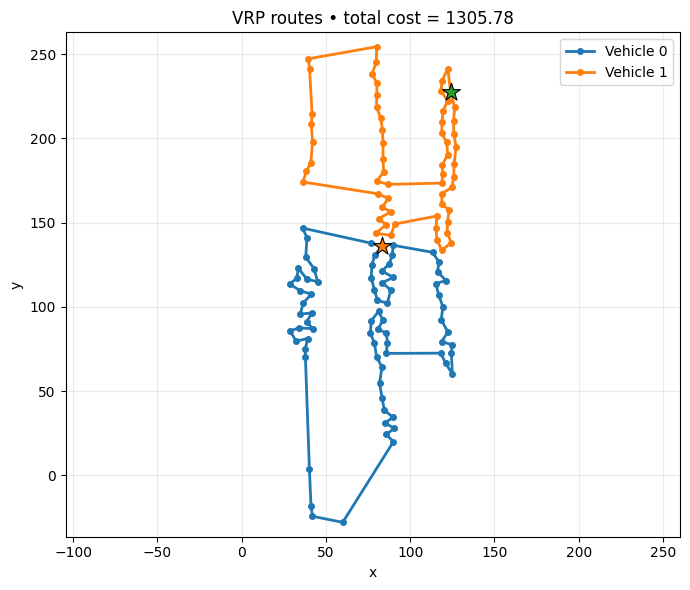

In [43]:
def _xy_of(node_id):
    # coords sejajar dengan `nodes`, dan `idx` memetakan id -> index
    return coords[idx[node_id], 0], coords[idx[node_id], 1]

def plot_routes_matplotlib(routes, starts=None, ends=None, show_ids=False, title="VRP routes"):
    fig, ax = plt.subplots(figsize=(7, 6))

    # plot semua titik sebagai background tipis
    ax.scatter(coords[:,0], coords[:,1], s=10, alpha=0.3, label="_all_points_bg")

    # gambar tiap rute
    for v, route in enumerate(routes):
        if len(route) == 0:
            continue

        # ambil koordinat sepanjang rute (termasuk node terakhir = end)
        xs, ys = [], []
        for nid in route:
            x, y = _xy_of(nid)
            xs.append(x); ys.append(y)

        # garis rutenya
        ax.plot(xs, ys, marker='o', linewidth=2, markersize=4, label=f"Vehicle {v}")

        # tandai start & end
        s_id = starts[v] if starts is not None else route[0]
        e_id = ends[v]   if ends is not None   else route[-1]
        sx, sy = _xy_of(s_id)
        ex, ey = _xy_of(e_id)

        ax.scatter([sx],[sy], marker='*', s=180, edgecolor='k', linewidths=0.8, zorder=5, label=f"_start_{v}")
        if e_id != s_id:
            ax.scatter([ex],[ey], marker='s', s=90, edgecolor='k', linewidths=0.8, zorder=5, label=f"_end_{v}")

        # optional: tulis ID di titik
        if show_ids:
            for nid in route:
                x, y = _xy_of(nid)
                ax.text(x, y, str(nid), fontsize=8, ha='right', va='bottom')

    ax.set_title(title)
    ax.set_xlabel("x"); ax.set_ylabel("y")
    ax.legend()
    ax.axis("equal")
    ax.grid(True, alpha=0.25)
    plt.tight_layout()
    plt.show()

plot_routes_matplotlib(
    routes=res["routes"],
    starts=res["starts"],
    ends=None,                # None -> otomatis dari list rute
    show_ids=False,
    title=f"VRP routes • total cost = {res['total_cost']:.2f}"
)

In [44]:
def plot_clustered_routes_matplotlib(cluster_routes, show_ids=False, title=None):
    fig, ax = plt.subplots(figsize=(7, 6))

    # background semua titik
    ax.scatter(coords[:,0], coords[:,1], s=10, alpha=0.25, label="_all_points_bg")

    for c, route in enumerate(cluster_routes):
        if not route:
            continue

        # urutan titik termasuk menutup ke awal (jika L>=2)
        xs, ys = [], []
        for nid in route:
            x, y = _xy_of(nid)
            xs.append(x); ys.append(y)
        if len(route) >= 2:
            x0, y0 = _xy_of(route[0])
            xs.append(x0); ys.append(y0)

        ax.plot(xs, ys, marker='o', linewidth=2, markersize=4, label=f"Cluster {c}")

        # tandai start (node pertama di list)
        sx, sy = _xy_of(route[0])
        ax.scatter([sx],[sy], marker='*', s=160, edgecolor='k', linewidths=0.8, zorder=5, label=f"_start_{c}")

        if show_ids:
            for nid in route:
                x, y = _xy_of(nid)
                ax.text(x, y, str(nid), fontsize=8, ha='right', va='bottom')

    if title is None:
        title = "Lovebird (clustered) routes"
    ax.set_title(title)
    ax.set_xlabel("x"); ax.set_ylabel("y")
    ax.legend()
    ax.axis("equal")
    ax.grid(True, alpha=0.25)
    plt.tight_layout()
    plt.show()

# Lovebird Initial Algorithm

In [45]:
def swap_two(tour, i, j): # red
    new = tour[:]
    if j - i < 4:
        return interchange(new, i, j)

    mid = new[i:j+1]
    k = len(mid) // 2
    seg1 = mid[:k]
    seg2 = mid[k:]
    new[i:i+k] = seg2
    new[i+k:j+1] = seg1
    return new

def flip(tour, i, j): # peach
    new = tour[:]
    new[i:j+1] = reversed(new[i:j+1])
    return new

def interchange(tour, i, j): # green
    new = tour[:]
    new[i], new[j] = new[j], new[i]
    return new

def slide(tour, i, j): # yellow
    new = tour[:]
    city = new.pop(i)
    new.insert(j, city)
    return new

def guided_swap(tour, i, j): # blue
    new = flip(tour, i, j)
    return interchange(new, i, j)

def scramble(tour): # gray
    new = tour[:]
    random.shuffle(new)
    return new

In [46]:
# Fungsi untuk RouletteWheel (untuk pemilihan titik secara probabilistik)
def roulette_wheel(population, fitness):
    total_fitness = sum(fitness)
    selection = random.uniform(0, total_fitness)
    current_sum = 0
    for i, individual in enumerate(population):
        current_sum += fitness[i]
        if current_sum >= selection:
            return individual
    return population[-1]  # fallback jika tidak ada yang terpilih

In [47]:
# ==== helper: bangun mapping kluster -> daftar node (urut sesuai nodes) ====
def _clusters_from_labels(nodes, labels):
    K = int(max(labels)) + 1
    clusters = {c: [] for c in range(K)}
    for n, l in zip(nodes, labels):
        clusters[int(l)].append(n)
    return clusters, K

def lovebird_algorithm_clustered(labels, nodes, maxGeneration, popSize, seed=None):

    rng = random.Random(seed)
    EPS = 1e-12

    # bangun kluster -> daftar node (tetap fix; tidak ada perpindahan antar kluster)
    cluster_nodes, K = _clusters_from_labels(nodes, labels)

    # ---- inisialisasi populasi: permutasi acak per kluster ----
    def _random_individual():
        indiv = []
        for c in range(K):
            r = cluster_nodes[c][:]
            rng.shuffle(r)
            indiv.append(r)
        return indiv

    population = [_random_individual() for _ in range(popSize)]

    # biaya awal populasi (sekali jalan)
    pop_costs = [sum(total_distance(r) for r in ind) for ind in population]

    # best awal
    best_idx = min(range(popSize), key=lambda i: pop_costs[i])
    best_solution = [r[:] for r in population[best_idx]]
    best_fitness = pop_costs[best_idx]
    history = [best_fitness]

    # ---- GA Loop ----
    for g in range(maxGeneration):
        # fitness = 1/cost
        fitness = [1.0/c if c > 0 else 1e9 for c in pop_costs]

        new_population = []
        new_costs = []

        for _ in range(popSize):
            # -------- selection: roulette --------
            parent = roulette_wheel(population, fitness)

            # salin individu (list of routes)
            T = [r[:] for r in parent]

            # ----- mutation: pilih kluster acak, mutasi satu rute -----
            v = rng.randrange(K) if K > 0 else 0
            r = T[v]
            L = len(r)
            if L > 1:
                if rng.random() < 0.9 and L >= 2:
                    i_idx, j_idx = sorted(rng.sample(range(L), 2))
                    op = rng.choice([1, 2, 3, 4, 5])
                    if op == 1:
                        r = swap_two(r, i_idx, j_idx)
                    elif op == 2:
                        r = flip(r, i_idx, j_idx)
                    elif op == 3:
                        r = interchange(r, i_idx, j_idx)
                    elif op == 4:
                        r = slide(r, i_idx, j_idx)
                    else:
                        r = guided_swap(r, i_idx, j_idx)
                else:
                    r = scramble(r)
                T[v] = r

            # hitung biaya awal kandidat
            route_costs = [total_distance(rr) for rr in T]
            total_cost = float(sum(route_costs))

            # ---------- local search per kluster (first-improvement) ----------
            def _improve_route(route, current_cost):
                """apply SWAP lalu 2-OPT (FLIP) circular; return (route_baru, delta_total)"""
                Lr = len(route)
                if Lr <= 2:
                    return route, 0.0

                improved_outer = True
                total_delta = 0.0

                while improved_outer:
                    improved_outer = False

                    # ---- SWAP circular ----
                    made_swap = True
                    while made_swap:
                        made_swap = False
                        if Lr <= 2:
                            break
                        accepted = False
                        i = 0
                        while i < Lr - 1 and not accepted:
                            j = i + 1
                            while j < Lr and not accepted:
                                a_idx, c_idx = i, j
                                aL = route[(a_idx - 1) % Lr]
                                a  = route[a_idx]
                                b  = route[(a_idx + 1) % Lr]
                                cL = route[(c_idx - 1) % Lr]
                                c  = route[c_idx]
                                d  = route[(c_idx + 1) % Lr]

                                adjacent = (c_idx == a_idx + 1) or (a_idx == 0 and c_idx == Lr - 1)
                                if adjacent:
                                    if c_idx == a_idx + 1:
                                        old = D[idx[aL], idx[a]] + D[idx[a], idx[c]] + D[idx[c], idx[d]]
                                        new = D[idx[aL], idx[c]] + D[idx[c], idx[a]] + D[idx[a], idx[d]]
                                    else:
                                        old = D[idx[cL], idx[c]] + D[idx[c], idx[a]] + D[idx[a], idx[b]]
                                        new = D[idx[cL], idx[a]] + D[idx[a], idx[c]] + D[idx[c], idx[b]]
                                else:
                                    old = (D[idx[aL], idx[a]] + D[idx[a], idx[b]] +
                                           D[idx[cL], idx[c]] + D[idx[c], idx[d]])
                                    new = (D[idx[aL], idx[c]] + D[idx[c], idx[b]] +
                                           D[idx[cL], idx[a]] + D[idx[a], idx[d]])
                                delta = new - old
                                if delta < -EPS:
                                    route[a_idx], route[c_idx] = route[c_idx], route[a_idx]
                                    total_delta += delta
                                    made_swap = True
                                    improved_outer = True
                                    accepted = True
                                else:
                                    j += 1
                            if not accepted:
                                i += 1
                        if made_swap:
                            break  # restart

                    # ---- 2-OPT / FLIP circular ----
                    made_flip = True
                    while made_flip:
                        made_flip = False
                        if Lr <= 2:
                            break
                        accepted = False
                        i = 0
                        while i < Lr - 1 and not accepted:
                            j = i + 1
                            while j < Lr and not accepted:
                                if i == 0 and j == Lr - 1:
                                    j += 1
                                    continue
                                ap = route[(i - 1) % Lr]
                                a  = route[i]
                                c  = route[j]
                                dn = route[(j + 1) % Lr]
                                old = D[idx[ap], idx[a]] + D[idx[c], idx[dn]]
                                new = D[idx[ap], idx[c]] + D[idx[a], idx[dn]]
                                delta = new - old
                                if delta < -EPS:
                                    route[i:j+1] = reversed(route[i:j+1])
                                    total_delta += delta
                                    made_flip = True
                                    improved_outer = True
                                    accepted = True
                                else:
                                    j += 1
                            if not accepted:
                                i += 1
                        if made_flip:
                            break  # restart

                return route, total_delta

            # improve semua kluster
            for v in range(K):
                route_before = T[v]
                route_after, delta = _improve_route(route_before, route_costs[v])
                if delta != 0.0:
                    T[v] = route_after
                    route_costs[v] += delta
                    total_cost += delta

            new_population.append(T)
            new_costs.append(total_cost)

        # elitism
        gen_best_idx = min(range(popSize), key=lambda i: new_costs[i])
        if new_costs[gen_best_idx] < best_fitness - EPS:
            best_fitness = new_costs[gen_best_idx]
            best_solution = [r[:] for r in new_population[gen_best_idx]]

        population = new_population
        pop_costs  = new_costs
        history.append(best_fitness)

    # biaya per kluster untuk best_solution
    per_cluster_costs = [total_distance(r) for r in best_solution]
    # total (float)
    best_fitness = float(sum(per_cluster_costs))
    return best_solution, best_fitness, history, per_cluster_costs


In [48]:
# labels = ...   # hasil KMeans, sejajar dengan nodes
best_sol_l, total_cost_l, hist_l, per_costs_l = lovebird_algorithm_clustered(
    labels, nodes, maxGeneration=10, popSize=10
)

print("Biaya per kluster:", per_costs_l)
print("Total biaya:", total_cost_l)
for i, r in enumerate(best_sol_l, 1):
    print(f"Rute kluster {i} (|r|={len(r)}):", r)

Biaya per kluster: [748.9400046864858, 577.5000164977529]
Total biaya: 1326.4400211842387
Rute kluster 1 (|r|=75): [26, 11, 103, 42, 4, 95, 133, 111, 63, 23, 107, 34, 72, 40, 81, 37, 96, 132, 62, 93, 15, 106, 110, 54, 29, 52, 117, 10, 80, 51, 27, 59, 125, 82, 3, 90, 114, 128, 44, 108, 6, 41, 116, 18, 58, 78, 38, 53, 135, 112, 8, 84, 69, 85, 16, 60, 76, 20, 77, 88, 47, 115, 30, 55, 71, 1, 130, 101, 43, 123, 67, 50, 129, 21, 124]
Rute kluster 2 (|r|=60): [104, 113, 64, 25, 120, 70, 12, 92, 32, 127, 48, 98, 131, 89, 33, 100, 126, 68, 118, 61, 45, 46, 19, 121, 109, 28, 87, 122, 73, 57, 134, 14, 65, 7, 86, 22, 79, 35, 17, 56, 99, 9, 49, 94, 24, 105, 36, 91, 5, 97, 31, 83, 102, 13, 119, 75, 2, 66, 74, 39]


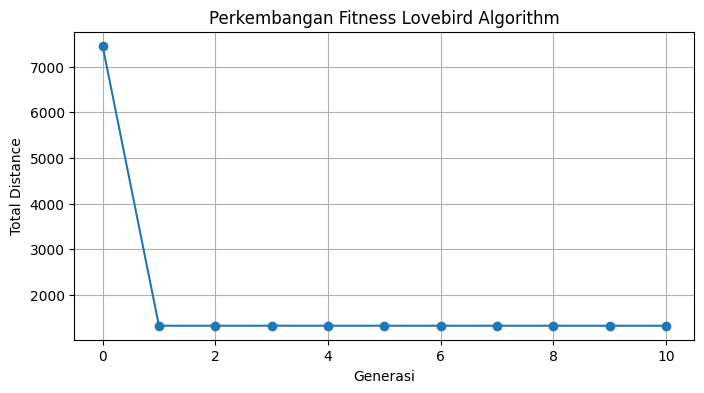

In [49]:
# Plot history
plt.figure(figsize=(8,4))
plt.plot(hist_l, marker='o')
plt.title("Perkembangan Fitness Lovebird Algorithm")
plt.xlabel("Generasi")
plt.ylabel("Total Distance")
plt.grid(True)
plt.show()

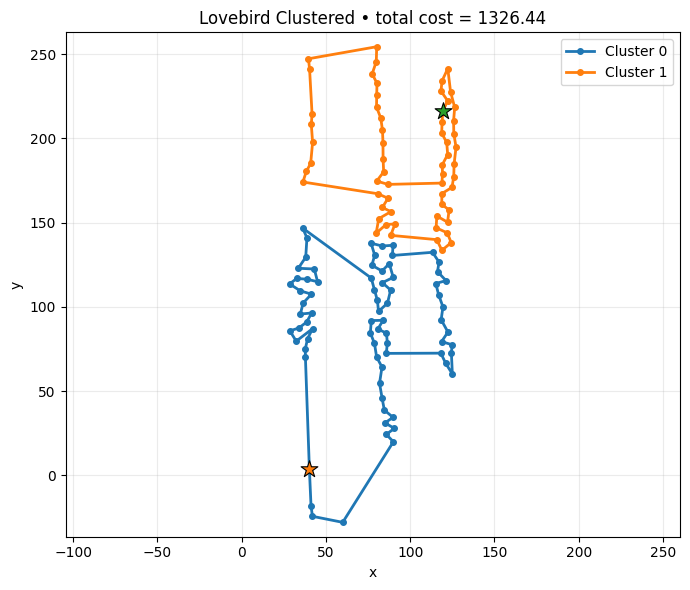

In [50]:
# --- contoh pakai hasil lovebird ---
plot_clustered_routes_matplotlib(
    best_sol_l,
    show_ids=False,
    title=f"Lovebird Clustered • total cost = {total_cost_l:.2f}"
)

# Local Lovebird Algorithm

In [51]:
def lovebird_local_search(
    maxLoop,
    clusters=None,               # <- optional: list of list node IDs per cluster
    labels=None, nodes=None,     # <- optional: jika ada labels dari KMeans + urutan nodes
    initial_solution=None,       # <- optional: seed awal (list of routes)
    time_budget=None,
    check_every=4096
):

    # --- util waktu ---
    t0 = time.perf_counter()
    def time_up():
        return (time_budget is not None) and ((time.perf_counter() - t0) >= time_budget)

    # --- bangun current (list of routes) sesuai prioritas input ---
    if clusters is not None:
        # deep copy, jaga urutan tiap kluster apa adanya
        current = [r[:] for r in clusters if len(r) > 0]
    elif (labels is not None) and (nodes is not None):
        # bangun kluster dari labels sesuai urutan nodes
        lab_arr = np.asarray(labels)
        K = int(lab_arr.max()) + 1 if lab_arr.size > 0 else 0
        tmp = {c: [] for c in range(K)}
        for n, l in zip(nodes, lab_arr):
            tmp[int(l)].append(n)
        current = [tmp[c] for c in range(K) if len(tmp[c]) > 0]
    elif initial_solution is not None:
        current = [r[:] for r in initial_solution if len(r) > 0]
    else:
        ids_copy = ids[:]
        random.shuffle(ids_copy)
        current = [ids_copy]  # fallback: satu kendaraan

    # Jika tidak ada rute, kembalikan trivial
    if len(current) == 0:
        return [], 0.0, [0.0], []

    # --- biaya awal ---
    route_costs = [total_distance(r) for r in current]
    total_cost  = float(sum(route_costs))
    best_solution = [r[:] for r in current]
    best_fitness = total_cost
    history = [best_fitness]

    EPS = 1e-12
    ops = 0  # throttle untuk pengecekan time_budget

    # --- helper improve satu rute dengan 2-OPT circular (first-improvement) ---
    def _improve_route(route):
        L = len(route)
        if L <= 2:
            return 0.0  # delta total
        total_delta = 0.0
        improved = True
        while improved:
            improved = False
            accepted_outer = False
            i = 0
            while i < L - 1 and not accepted_outer:
                j = i + 1
                while j < L and not accepted_outer:
                    # throttle waktu
                    nonlocal ops
                    ops += 1
                    if (ops % check_every == 0) and time_up():
                        return total_delta  # keluar rapi: kembalikan delta yang sudah terjadi

                    # larang memotong edge yang sama (i=0, j=L-1) karena tour circular
                    if i == 0 and j == L - 1:
                        j += 1
                        continue

                    ap = route[(i - 1) % L]
                    a  = route[i]
                    c  = route[j]
                    dn = route[(j + 1) % L]

                    old = D[idx[ap], idx[a]] + D[idx[c], idx[dn]]
                    new = D[idx[ap], idx[c]] + D[idx[a], idx[dn]]
                    delta = new - old
                    if delta < -EPS:
                        route[i:j+1] = reversed(route[i:j+1])
                        total_delta += delta
                        improved = True
                        accepted_outer = True  # restart dari awal rute
                    else:
                        j += 1
                if not accepted_outer:
                    i += 1
        return total_delta

    # --- main loops ---
    for _ in range(maxLoop):
        if time_up():
            break

        # Turun bukit: improve SEMUA rute (per kluster) sampai lokal optimum
        any_improved = True
        while any_improved and (not time_up()):
            any_improved = False
            for v in range(len(current)):
                if time_up():
                    break
                delta = _improve_route(current[v])
                if abs(delta) > 0.0:
                    route_costs[v] += delta
                    total_cost += delta
                    any_improved = True

        # update best setelah satu fase improve
        if total_cost < best_fitness - EPS:
            best_fitness = float(total_cost)
            best_solution = [rr[:] for rr in current]

        if time_up():
            break

        # Eksplorasi/“mutasi ringan”: pilih satu rute acak, lakukan mutasi (flip/interchange/slide)
        T = [r[:] for r in current]
        v = random.randrange(len(T))
        r = T[v]
        if len(r) > 1:
            i_idx, j_idx = sorted(random.sample(range(len(r)), 2))
            op = random.choice([2, 3, 4])  # 2:flip, 3:interchange, 4:slide
            if op == 2:
                r = flip(r, i_idx, j_idx)
            elif op == 3:
                r = interchange(r, i_idx, j_idx)
            elif op == 4:
                r = slide(r, i_idx, j_idx)
        T[v] = r
        current = T

        # Recompute biaya rute & total
        route_costs = [total_distance(rr) for rr in current]
        total_cost = float(sum(route_costs))
        history.append(best_fitness)

    # siapkan ringkasan biaya per kluster untuk best_solution
    per_cluster_costs = [total_distance(r) for r in best_solution]
    best_fitness = float(sum(per_cluster_costs))
    return best_solution, best_fitness, history, per_cluster_costs

In [52]:
best_sol_ll, total_cost_ll, hist_ll, per_costs_ll = lovebird_local_search(
    maxLoop=2000,
    labels=labels,
    nodes=nodes,
    time_budget=10.0
)

print("Biaya per kluster:", per_costs_ll)
print("Total biaya:", total_cost_ll)
for i, r in enumerate(best_sol_ll, 1):
    print(f"Rute kluster {i} (|r|={len(r)}):", r)

Biaya per kluster: [740.4829175870783, 574.1504269304498]
Total biaya: 1314.6333445175283
Rute kluster 1 (|r|=75): [3, 90, 114, 128, 58, 78, 53, 135, 8, 84, 38, 69, 18, 116, 41, 44, 108, 6, 85, 16, 60, 76, 47, 115, 30, 88, 20, 77, 55, 71, 1, 130, 101, 50, 43, 123, 67, 129, 21, 124, 26, 11, 103, 42, 4, 95, 133, 111, 63, 23, 107, 34, 72, 40, 81, 37, 96, 112, 132, 62, 93, 15, 106, 110, 54, 29, 52, 117, 10, 80, 51, 27, 59, 125, 82]
Rute kluster 2 (|r|=60): [46, 19, 118, 68, 109, 121, 87, 28, 122, 73, 57, 134, 14, 102, 31, 83, 65, 7, 86, 22, 79, 35, 17, 56, 99, 9, 49, 94, 24, 105, 36, 91, 5, 97, 74, 39, 104, 64, 25, 120, 70, 113, 12, 92, 32, 66, 127, 2, 48, 75, 119, 98, 131, 13, 89, 33, 100, 126, 61, 45]


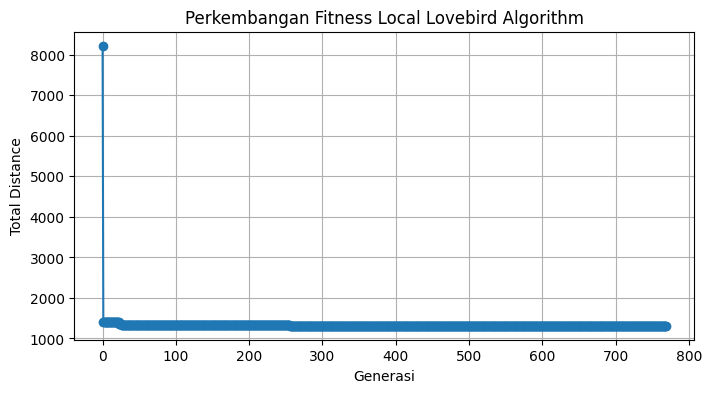

In [53]:
# Plot history
plt.figure(figsize=(8,4))
plt.plot(hist_ll, marker='o')
plt.title("Perkembangan Fitness Local Lovebird Algorithm")
plt.xlabel("Generasi")
plt.ylabel("Total Distance")
plt.grid(True)
plt.show()

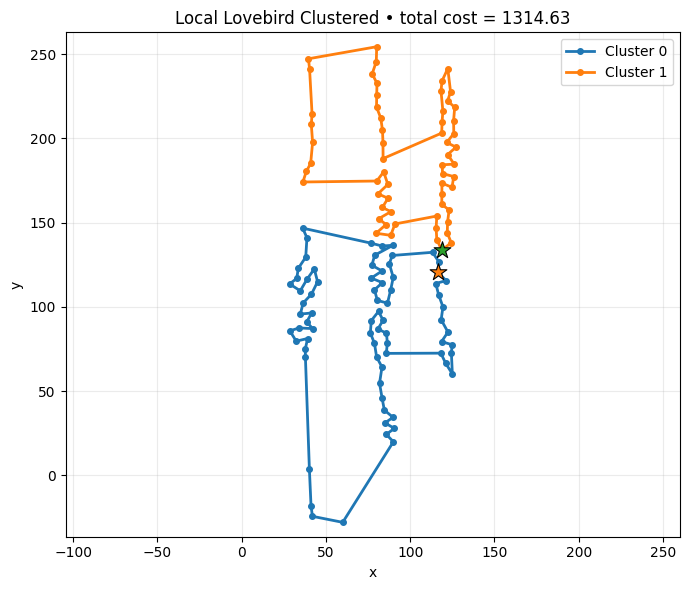

In [54]:
# --- contoh pakai hasil lovebird ---
plot_clustered_routes_matplotlib(
    best_sol_ll,
    show_ids=False,
    title=f"Local Lovebird Clustered • total cost = {total_cost_ll:.2f}"
)

# Iterated Lovebird Algorithm

In [55]:
def double_bridge(route):
    L = len(route)
    if L < 8:
        return route[:]  # sama seperti semula
    rnd = random
    i1, i2, i3, i4 = sorted(rnd.sample(range(L), 4))
    segA = route[:i1]
    segB = route[i1:i2]
    segC = route[i2:i3]
    segD = route[i3:i4]
    segE = route[i4:]
    # varian klasik (tidak diubah)
    return segA + segC + segB + segD + segE


# --- 1) OR-Opt intra-route: pilih posisi sisip terbaik (circular, O(L)) ---
def or_opt_intra(route, k=2):
    L = len(route)
    if L < k + 2:
        return route[:]

    rnd = random
    Dm  = D
    ix  = idx

    # pilih blok [i..i+k-1] (tanpa wrap)
    i = rnd.randint(0, L - k - 1)
    a = route[i]
    b = route[i + k - 1]
    p = route[i - 1] if i > 0 else route[-1]
    n = route[i + k] if (i + k) < L else route[0]

    block    = route[i:i+k]
    residual = route[:i] + route[i+k:]
    M        = len(residual)

    # biaya pelepasan blok dari posisi lama (circular TSP)
    base_remove = -Dm[ix[p]][ix[a]] - Dm[ix[b]][ix[n]] + Dm[ix[p]][ix[n]]

    best_j = None
    best_delta = 0.0
    # sisip sebelum residual[j], j=0..M-1 mewakili sisi (x->y)
    for j in range(M):
        x = residual[j - 1] if j > 0 else residual[-1]
        y = residual[j]
        insert_cost = -Dm[ix[x]][ix[y]] + Dm[ix[x]][ix[a]] + Dm[ix[b]][ix[y]]
        delta = base_remove + insert_cost
        if delta < best_delta:
            best_delta = delta
            best_j = j

    if best_j is None:
        return route[:]  # tak ada perbaikan

    # sisipkan block di posisi terbaik
    new_route = residual[:best_j] + block + residual[best_j:]
    return new_route


def perturb_multi_simple(solution, p_intra=0.95, prefer_k3=False, max_block=6):

    sol = [r[:] for r in solution]
    rnd = random
    rrand = rnd.random

    # --- intra OR-Opt mayoritas ---
    did_intra = False
    if rrand() < p_intra:
        cand_idxs = [i for i, r in enumerate(sol) if len(r) >= 5]
        if cand_idxs:
            v = rnd.choice(cand_idxs)
            k = 3 if (prefer_k3 and len(sol[v]) >= 5) else 2
            sol[v] = or_opt_intra(sol[v], k=k)
            did_intra = True

    # --- strong shake: double-bridge hanya saat stagnan (prefer_k3 True) ---
    if prefer_k3 and sol:
        v2 = max(range(len(sol)), key=lambda t: len(sol[t]))
        if len(sol[v2]) >= 8 and rrand() < 0.07:
            sol[v2] = double_bridge(sol[v2])

    # --- scramble kecil (5%) pada rute terpanjang ---
    if rrand() < 0.05 and sol:
        v2 = max(range(len(sol)), key=lambda t: len(sol[t]))
        L = len(sol[v2])
        if L >= 6:
            m = rnd.randint(3, min(max_block, L - 1))
            i = rnd.randint(0, L - m)
            sub = sol[v2][i:i+m]
            rnd.shuffle(sub)
            sol[v2] = sol[v2][:i] + sub + sol[v2][i+m:]

    return sol

In [56]:
def iterated_lovebird(max_iter=30, local_gen=120,
                      clusters=None,              # <- NEW: list of list node IDs per kluster
                      labels=None, nodes=None,    # <- NEW: alternatif masukan
                      initial_solution=None,      # seed awal (list of routes)
                      patience=3, seed=None, budget_s=None
                      ):

    if seed is not None:
        random.seed(seed)

    # --- siapkan solusi awal yang menghormati kluster ---
    def _init_solution_from_inputs():
        if clusters is not None:
            # gunakan urutan apa adanya per kluster
            cur = [r[:] for r in clusters if len(r) > 0]
            return cur if cur else [[]]
        elif (labels is not None) and (nodes is not None):
            lab_arr = np.asarray(labels)
            K = int(lab_arr.max()) + 1 if lab_arr.size > 0 else 0
            tmp = {c: [] for c in range(K)}
            for n, l in zip(nodes, lab_arr):
                tmp[int(l)].append(n)
            cur = [tmp[c] for c in range(K) if tmp[c]]
            return cur if cur else [[]]
        elif initial_solution is not None:
            return [r[:] for r in initial_solution if len(r) > 0] or [[]]
        else:
            ids_copy = ids[:]; random.shuffle(ids_copy)
            return [ids_copy]  # single-route fallback

    # alias
    ls = lovebird_local_search

    # --- time budget helper ---
    SAFETY   = 0.05
    t_start  = time.perf_counter()
    deadline = (t_start + budget_s) if budget_s is not None else None

    def time_left():
        return None if deadline is None else max(0.0, deadline - time.perf_counter())

    # --- LS awal: hormati input kluster/seed ---
    start_solution = _init_solution_from_inputs()

    rem = time_left()
    if rem is not None and rem <= SAFETY:
        best_sol = [r[:] for r in start_solution]
        best_cost = sum(total_distance(r) for r in best_sol)
        return best_sol, float(best_cost), [float(best_cost)]

    best_sol, best_cost, _hist0, _ = ls(
        maxLoop=local_gen,
        clusters=start_solution,        # <- pass sebagai clusters agar LS tetap intra-cluster
        time_budget=(rem - SAFETY) if rem is not None else None
    )
    history = [best_cost]
    no_improve = 0

    # --- ILS loop ---
    for _ in range(max_iter):
        rem = time_left()
        if rem is not None and rem <= SAFETY:
            break

        prefer_k3 = (no_improve >= patience)
        max_block = 6 + 2 * (no_improve // patience)

        # Perturbasi dari best; default intra-cluster (kecuali allow_inter_cluster=True)
        perturbed = perturb_multi_simple(
            best_sol,
            p_intra=0.9,
            prefer_k3=prefer_k3,
            max_block=max_block
        )

        rem = time_left()
        if rem is not None and rem <= SAFETY:
            break

        # Local search lagi (tetap intra-cluster)
        imp_sol, imp_cost, _, _ = ls(
            maxLoop=local_gen,
            clusters=perturbed,
            time_budget=(rem - SAFETY) if rem is not None else None
        )

        if imp_cost < best_cost - 1e-9:
            best_sol = [r[:] for r in imp_sol]
            best_cost = imp_cost
            no_improve = 0
        else:
            no_improve += 1

        # Hard restart kecil saat buntu—tetap hormati kluster; boleh cross-move kalau diizinkan
        if no_improve >= 2 * patience:
            rem = time_left()
            if rem is None or rem > SAFETY + 0.1:
                strong = perturb_multi_simple(
                    best_sol, p_intra=0.3, prefer_k3=True, max_block=12
                )
                rem = time_left()
                if rem is not None and rem <= SAFETY:
                    break

                best_sol2, best_cost2, _, _ = ls(
                    maxLoop=local_gen,
                    clusters=strong,
                    time_budget=(rem - SAFETY) if rem is not None else None
                )
                if best_cost2 < best_cost - 1e-9:
                    best_sol, best_cost = best_sol2, best_cost2
                    no_improve = 0

        history.append(best_cost)

    return best_sol, float(best_cost), history

In [57]:
best_sol_il, best_cost_il, hist_il = iterated_lovebird(
    max_iter=20, local_gen=20,
    labels=labels, nodes=nodes,
    budget_s=10.0
)

# Ringkasan biaya
per_costs_il = [total_distance(r) for r in best_sol_il]  # biaya per kluster
total_cost_il = sum(per_costs_il)                         # sama dengan best_cost (cek konsistensi)

print("Biaya per kluster:", per_costs_il)
print("Total biaya (sum):", total_cost_il)
print("Total biaya (best_cost dari ILS):", best_cost_il)

# Cetak rute per kluster
for i, r in enumerate(best_sol_il, 1):
    print(f"Rute kluster {i} (|r|={len(r)}): {r}")

Biaya per kluster: [733.7104692784643, 574.5429262984569]
Total biaya (sum): 1308.2533955769213
Total biaya (best_cost dari ILS): 1308.2533955769213
Rute kluster 1 (|r|=75): [1, 130, 101, 50, 43, 123, 67, 129, 21, 124, 26, 11, 103, 42, 4, 95, 133, 111, 63, 23, 107, 34, 72, 40, 81, 37, 62, 96, 112, 132, 93, 15, 106, 110, 54, 29, 52, 117, 10, 80, 51, 27, 59, 125, 82, 3, 90, 114, 44, 128, 58, 78, 53, 135, 8, 84, 38, 69, 18, 116, 41, 108, 6, 85, 16, 60, 20, 77, 88, 76, 47, 115, 30, 55, 71]
Rute kluster 2 (|r|=60): [45, 46, 19, 118, 109, 121, 87, 28, 122, 73, 57, 134, 14, 102, 31, 83, 65, 7, 86, 22, 79, 35, 17, 56, 99, 9, 49, 94, 24, 105, 36, 91, 5, 97, 74, 39, 104, 113, 64, 25, 120, 70, 12, 92, 32, 66, 127, 2, 48, 75, 119, 98, 131, 13, 89, 33, 100, 68, 126, 61]


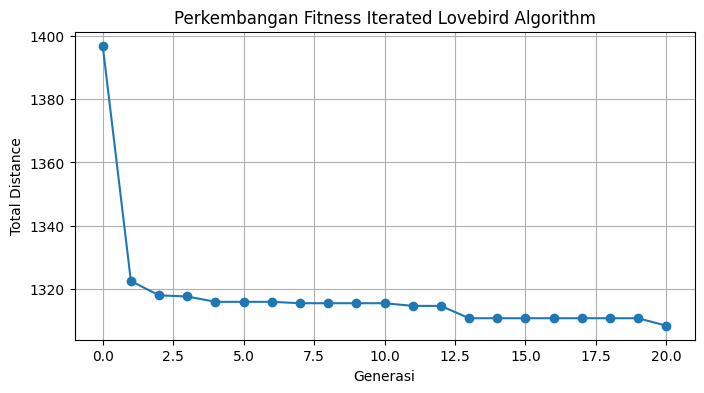

In [58]:
# Plot history
plt.figure(figsize=(8,4))
plt.plot(hist_il, marker='o')
plt.title("Perkembangan Fitness Iterated Lovebird Algorithm")
plt.xlabel("Generasi")
plt.ylabel("Total Distance")
plt.grid(True)
plt.show()

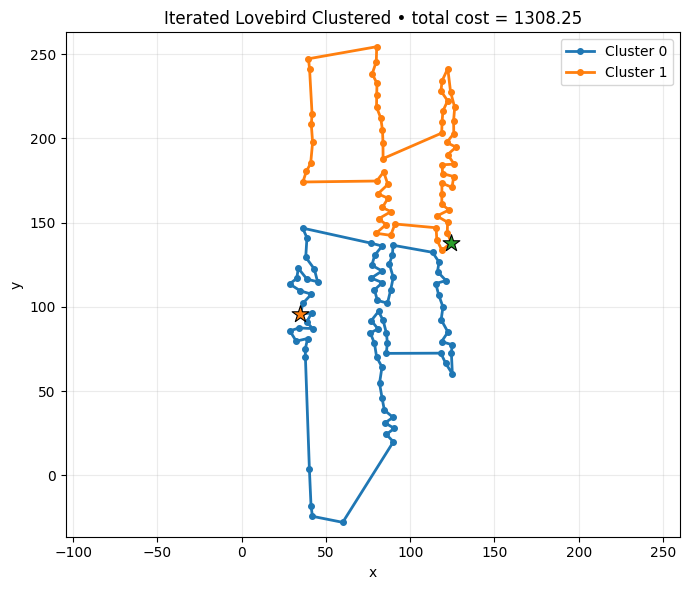

In [59]:
# --- contoh pakai hasil lovebird ---
plot_clustered_routes_matplotlib(
    best_sol_il,
    show_ids=False,
    title=f"Iterated Lovebird Clustered • total cost = {best_cost_il:.2f}"
)

# Hyper Iterated Lovebird Algorithm

In [60]:
# def or_opt_k1_once(route):

#     L = len(route)
#     if L < 3:
#         return route[:], 0.0, False

#     Dm = D
#     ix = idx
#     EPS = 1e-12

#     # Precompute index D untuk semua node di route (hemat lookup)
#     r_ix = [ix[n] for n in route]

#     best_delta = 0.0
#     best_move  = None  # (i, y_idx_target) => sisip sebelum node di posisi y_idx_target (setelah pop)

#     for i in range(L):
#         a_idx = i
#         a = route[a_idx]; ia = r_ix[a_idx]

#         p_idx = a_idx - 1 if a_idx > 0 else L - 1
#         n_idx = a_idx + 1 if (a_idx + 1) < L else 0

#         ip = r_ix[p_idx]; inn = r_ix[n_idx]

#         # Lepas a: (p->a, a->n) jadi (p->n)
#         base_remove = -Dm[ip][ia] - Dm[ia][inn] + Dm[ip][inn]

#         # 1) Cek semua sisi (x->y) dari tur asli KECUALI yang menyentuh a
#         #    (yaitu j == a_idx-1 => (p->a) dan j == a_idx => (a->n))
#         j = 0
#         while j < L:
#             if j != p_idx and j != a_idx:
#                 x_idx = j
#                 y_idx = j + 1 if (j + 1) < L else 0
#                 ix_x = r_ix[x_idx]; ix_y = r_ix[y_idx]

#                 insert_cost = -Dm[ix_x][ix_y] + Dm[ix_x][ia] + Dm[ia][ix_y]
#                 delta = base_remove + insert_cost
#                 if delta < best_delta - EPS:
#                     # sisip sebelum 'y' di list SETELAH a di-pop
#                     ins_pos = y_idx - (1 if y_idx > a_idx else 0)
#                     best_delta = delta
#                     best_move  = (a_idx, ins_pos)
#             j += 1

#         # 2) Tambahkan sisi (p->n) yang muncul setelah a dilepas
#         #    (setara dengan sisip sebelum 'n' pada list setelah pop)
#         insert_cost_pn = -Dm[ip][inn] + Dm[ip][ia] + Dm[ia][inn]
#         delta_pn = base_remove + insert_cost_pn
#         if delta_pn < best_delta - EPS:
#             # sisip sebelum 'n' pada list SETELAH pop
#             # posisi 'n' di list baru: jika n_idx > a_idx → n_idx-1, else n_idx
#             ins_pos = n_idx - (1 if n_idx > a_idx else 0)
#             best_delta = delta_pn
#             best_move  = (a_idx, ins_pos)

#     if best_move is None:
#         return route[:], 0.0, False

#     # Bangun rute baru sesuai best_move (pop + insert)
#     i_pop, ins_pos = best_move
#     new_route = route[:]             # salin ringan
#     node = new_route.pop(i_pop)
#     new_route.insert(ins_pos, node)
#     return new_route, best_delta, True

In [61]:
# def hyper_iterated_lovebird(
#     max_iter=10,
#     local_gen_shallow=8,
#     local_gen_deep=30,
#     deep_every=3,
#     patience=2,
#     initial_solution=None,
#     p_intra=0.95,
#     base_max_block=6,
#     budget_s=None,
#     seed=None,
#     # NEW ↓↓↓
#     clusters=None,             # list of list node IDs per cluster
#     labels=None, nodes=None,   # alternatif masukan (hasil KMeans)
#     allow_inter_cluster=False  # default: patuh kluster (no cross-move)
# ):
#     if seed is not None:
#         random.seed(seed)

#     # --- builder solusi awal dari input kluster/label ---
#     def _init_solution_from_inputs():
#         if clusters is not None:
#             cur = [r[:] for r in clusters if len(r) > 0]
#             return cur if cur else [[]]
#         elif (labels is not None) and (nodes is not None):
#             lab_arr = np.asarray(labels)
#             K = int(lab_arr.max()) + 1 if lab_arr.size > 0 else 0
#             tmp = {c: [] for c in range(K)}
#             for n, l in zip(nodes, lab_arr):
#                 tmp[int(l)].append(n)
#             cur = [tmp[c] for c in range(K) if tmp[c]]
#             return cur if cur else [[]]
#         elif initial_solution is not None:
#             return [r[:] for r in initial_solution if len(r) > 0] or [[]]
#         else:
#             ids_copy = ids[:]; random.shuffle(ids_copy)
#             return [ids_copy]  # fallback single-route

#     t_start = time.perf_counter()
#     deadline = (t_start + budget_s) if budget_s is not None else None
#     SAFETY = 0.05

#     def time_left():
#         return None if deadline is None else max(0.0, deadline - time.perf_counter())

#     # --- start solution (menghormati kluster) ---
#     start_solution = _init_solution_from_inputs()

#     # Waktu terlalu sempit → kembalikan cepat
#     rem = time_left()
#     if rem is not None and rem <= SAFETY:
#         best_sol = [r[:] for r in start_solution]
#         best_cost = sum(total_distance(r) for r in best_sol)
#         return best_sol, float(best_cost), [float(best_cost)]

#     # LS awal (cluster-aware)
#     sol0, cost0, _, _ = lovebird_local_search(
#         maxLoop=max(local_gen_deep, 10),
#         clusters=start_solution,                           # <-- penting
#         time_budget=(rem - SAFETY) if rem is not None else None
#     )
#     best_sol, best_cost = sol0, cost0
#     history = [best_cost]
#     no_improve = 0

#     elite  = [(best_cost, [r[:] for r in best_sol])]
#     ELITE_K = 3

#     for it in range(1, max_iter + 1):
#         rem = time_left()
#         if rem is not None and rem <= SAFETY:
#             break

#         prefer_k3 = (no_improve >= patience)
#         max_block = base_max_block + 2 * (no_improve // patience)

#         # Perturb dari best (default intra-kluster)
#         perturbed = perturb_multi_simple(
#             best_sol,
#             p_intra=p_intra,
#             prefer_k3=prefer_k3,
#             max_block=max_block,
#             allow_inter_cluster=allow_inter_cluster
#         )

#         # --- similarity guard (ringan) ---
#         def _hamming_routes(A, B):
#             diff = 0
#             for ra, rb in zip(A, B):
#                 m = min(len(ra), len(rb))
#                 for i in range(m):
#                     if ra[i] != rb[i]:
#                         diff += 1
#                 diff += abs(len(ra) - len(rb))
#             return diff

#         total_n = sum(len(r) for r in best_sol)
#         BASE_FRAC  = 0.05
#         EARLY_FRAC = 0.08
#         MID_FRAC   = 0.08
#         MIN_DIFF = max(8, int(BASE_FRAC * total_n))
#         plateau_after = max(3, 2 * patience)

#         diff = _hamming_routes(perturbed, best_sol)
#         need = MIN_DIFF
#         if it <= 2:
#             need = max(need, int(EARLY_FRAC * total_n))
#         elif no_improve >= plateau_after:
#             need = max(need, int(MID_FRAC * total_n))

#         if diff < need:
#             perturbed = perturb_multi_simple(
#                 best_sol,
#                 p_intra=max(0.6, p_intra - 0.2),
#                 prefer_k3=True,
#                 max_block=min(12, base_max_block + 2),
#                 allow_inter_cluster=allow_inter_cluster
#             )

#         use_deep = (it % deep_every == 0) or (no_improve >= patience)
#         depth = local_gen_deep if use_deep else local_gen_shallow

#         rem = time_left()
#         if rem is not None and rem <= SAFETY:
#             break

#         # # pre-repair: 1 langkah OR-Opt k=1 per route
#         # for v in range(len(perturbed)):
#         #     new_r, delta, ok = or_opt_k1_once(perturbed[v])
#         #     if ok:
#         #         perturbed[v] = new_r

#         FINISHER_TAIL = 1.0
#         remaining_iter = max(1, max_iter - it + 1)
#         MIN_BUDGET_SHALLOW = 0.50
#         MIN_BUDGET_DEEP    = 1.25

#         if rem is None:
#             ls_budget = None
#         else:
#             usable = max(0.0, rem - max(SAFETY, FINISHER_TAIL))
#             slot = usable / remaining_iter if remaining_iter > 0 else usable
#             slot *= (1.6 if use_deep else 1.0)
#             floor_need = MIN_BUDGET_DEEP if use_deep else MIN_BUDGET_SHALLOW
#             slot = max(slot, floor_need)
#             ls_budget = max(0.0, min(slot, usable - 0.01))

#         # LS iterasi (cluster-aware)
#         sol, cost, _, _ = lovebird_local_search(
#             maxLoop=depth,
#             clusters=perturbed,                               # <-- penting
#             time_budget=ls_budget
#         )

#         if all(abs(cost - c0) > 1e-7 for c0, _ in elite):
#             elite.append((cost, [r[:] for r in sol]))
#             elite.sort(key=lambda x: x[0])
#             if len(elite) > ELITE_K:
#                 elite.pop()

#         if cost < best_cost - 1e-9:
#             best_sol, best_cost = sol, cost
#             no_improve = 0
#         else:
#             no_improve += 1
#             rem = time_left()
#             if (no_improve >= 2 * patience) and (rem is None or rem > SAFETY + 0.1):
#                 strong = perturb_multi_simple(
#                     best_sol,
#                     p_intra=0.6,
#                     prefer_k3=True,
#                     max_block=min(12, base_max_block + 4),
#                     allow_inter_cluster=allow_inter_cluster
#                 )
#                 rem = time_left()
#                 if rem is not None and rem <= SAFETY:
#                     break
#                 sol2, cost2, _, _ = lovebird_local_search(
#                     maxLoop=local_gen_deep,
#                     clusters=strong,                              # <-- penting
#                     time_budget=(rem - SAFETY) if rem is not None else None
#                 )
#                 if cost2 < best_cost - 1e-9:
#                     best_sol, best_cost = sol2, cost2
#                     no_improve = 0

#         history.append(best_cost)

#     return best_sol, float(best_cost), history


In [62]:
def hyper_iterated_lovebird(
    max_iter=20,
    local_gen_shallow=8,
    local_gen_deep=40,
    deep_every=3,
    base_max_block=6,
    patience=2,
    initial_solution=None,
    clusters=None,
    labels=None, nodes=None,
    budget_s=None,
    seed=None
):
    if seed is not None:
        random.seed(seed)

    # --- solusi awal ---
    def _init_solution():
        if clusters is not None:
            cur = [r[:] for r in clusters if len(r) > 0]
            return cur if cur else [[]]

        elif (labels is not None) and (nodes is not None):
            lab_arr = np.asarray(labels)
            K = int(lab_arr.max()) + 1 if lab_arr.size > 0 else 0
            tmp = {c: [] for c in range(K)}
            for n, l in zip(nodes, lab_arr):
                tmp[int(l)].append(n)
            cur = [tmp[c] for c in range(K) if tmp[c]]
            return cur if cur else [[]]

        elif initial_solution is not None:
            cur = [r[:] for r in initial_solution if len(r) > 0]
            return cur if cur else [[]]

        else:
            ids_copy = ids[:]
            random.shuffle(ids_copy)
            return [ids_copy]

    # --- time handling ---
    t_start = time.perf_counter()
    deadline = (t_start + budget_s) if budget_s is not None else None
    SAFETY = 0.05

    def time_left():
        return None if deadline is None else max(0.0, deadline - time.perf_counter())

    start_solution = _init_solution()

    # fallback jika waktu sangat sempit
    rem = time_left()
    if rem is not None and rem <= SAFETY:
        per_costs = [total_distance(r) for r in start_solution]
        total_cost = float(sum(per_costs))
        return start_solution, total_cost, [total_cost], per_costs

    # --- LS awal pakai deep ---
    best_sol, best_cost, _, _ = lovebird_local_search(
        maxLoop=max(local_gen_deep, 10),
        clusters=start_solution,
        time_budget=(rem - SAFETY) if rem is not None else None
    )
    history = [best_cost]
    no_improve = 0

    # --- main ILS loop ---
    for it in range(1, max_iter + 1):

        # check time
        rem = time_left()
        if rem is not None and rem <= SAFETY:
            break

        # ======================================
        # 1) Block-size adaptif berdasarkan stagnasi
        # ======================================
        factor = no_improve // max(1, patience)
        max_block = min(base_max_block + 2 * factor, 20)

        # perturbasi
        perturbed = perturb_multi_simple(
            best_sol,
            p_intra=0.9,                      # tetap konstan (tidak adaptif)
            prefer_k3=(factor >= 1),          # aktifkan k3 saat stagnasi
            max_block=max_block
        )

        # ======================================
        # 2) Depth scheduling shallow/deep
        # ======================================
        use_deep = (it % deep_every == 0) or (no_improve >= patience)
        depth = local_gen_deep if use_deep else local_gen_shallow

        # LS
        rem = time_left()
        if rem is None:
            ls_budget = None
        else:
            ls_budget = max(0.0, rem - SAFETY)

        sol, cost, _, _ = lovebird_local_search(
            maxLoop=depth,
            clusters=perturbed,
            time_budget=ls_budget
        )

        # update
        if cost < best_cost - 1e-9:
            best_sol = [r[:] for r in sol]
            best_cost = cost
            no_improve = 0
        else:
            no_improve += 1

        history.append(best_cost)

    # per cluster cost
    per_cluster_costs = [total_distance(r) for r in best_sol]
    total_cost = float(sum(per_cluster_costs))

    return best_sol, total_cost, history

In [63]:
best_sol_ail, best_cost_ail, hist_ail = hyper_iterated_lovebird(
    max_iter=20, local_gen_shallow=10, local_gen_deep=40, deep_every=3,
    labels=labels, nodes=nodes, budget_s=20.0
)

# ringkasan hasil
per_costs_ail = [total_distance(r) for r in best_sol_ail]
print("Biaya per kluster:", per_costs_ail)
print("Total biaya:", sum(per_costs_ail))
for i, r in enumerate(best_sol_ail, 1):
    print(f"Rute kluster {i} (|r|={len(r)}): {r}")

Biaya per kluster: [735.5616258979226, 577.2200586299252]
Total biaya: 1312.7816845278478
Rute kluster 1 (|r|=75): [23, 63, 111, 133, 95, 4, 42, 103, 11, 26, 124, 21, 129, 67, 123, 43, 50, 101, 130, 1, 71, 55, 30, 115, 47, 76, 88, 77, 20, 60, 16, 85, 6, 41, 116, 69, 84, 8, 135, 53, 38, 78, 18, 58, 128, 108, 44, 114, 90, 3, 82, 125, 59, 27, 51, 80, 10, 117, 52, 29, 54, 110, 93, 62, 132, 112, 96, 37, 81, 15, 106, 40, 72, 34, 107]
Rute kluster 2 (|r|=60): [127, 32, 92, 12, 70, 120, 25, 64, 113, 104, 39, 74, 66, 2, 75, 119, 13, 102, 31, 97, 5, 91, 36, 105, 24, 94, 49, 9, 99, 56, 17, 35, 79, 22, 86, 7, 65, 83, 14, 134, 57, 73, 122, 28, 87, 121, 109, 19, 46, 45, 61, 126, 118, 68, 100, 33, 89, 131, 98, 48]


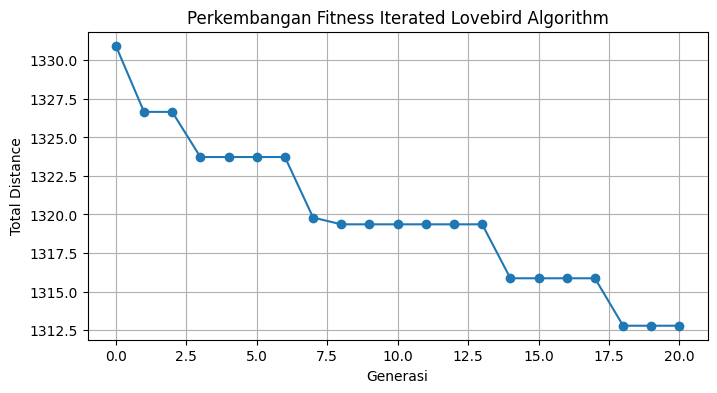

In [64]:
# Plot history
plt.figure(figsize=(8,4))
plt.plot(hist_ail, marker='o')
plt.title("Perkembangan Fitness Iterated Lovebird Algorithm")
plt.xlabel("Generasi")
plt.ylabel("Total Distance")
plt.grid(True)
plt.show()

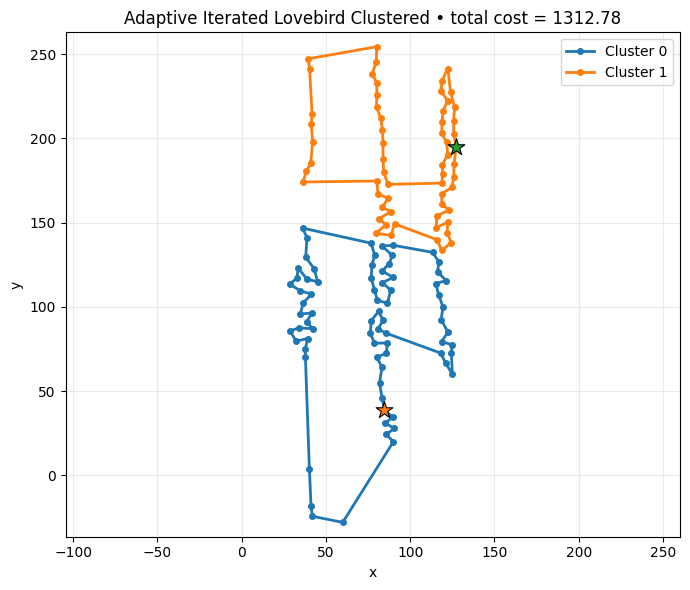

In [65]:
# --- contoh pakai hasil lovebird ---
plot_clustered_routes_matplotlib(
    best_sol_ail,
    show_ids=False,
    title=f"Adaptive Iterated Lovebird Clustered • total cost = {best_cost_ail:.2f}"
)

# Distance Counter

In [66]:
def route_distance(route):
    if not route or len(route) < 2:
        return 0.0
    s = 0.0
    for i in range(len(route) - 1):
        s += D[idx[route[i]], idx[route[i+1]]]
    return float(s)

# Contoh pemakaian:
sample_route = [8, 84, 69, 116, 41, 108, 6, 85, 16, 60, 20, 77, 88, 76, 47, 115, 30, 55, 71, 1, 130, 101, 50, 43, 123, 67, 129, 21, 124, 26, 11, 103, 42, 4, 95, 133, 111, 63, 23, 107, 34, 72, 40, 81, 37, 96, 112, 132, 62, 93, 15, 106, 110, 54, 29, 52, 117, 10, 80, 51, 27, 59, 125, 82, 3, 90, 114, 44, 128, 58, 18, 78, 38, 53, 135, 8]
distance = route_distance(sample_route)
print("Total distance:", distance)

Total distance: 731.5083748497522


# Testing

In [67]:
def _choose_starts_from_input(start_sol, labels, nodes, seed=None):
    """
    Pilih start per kluster:
    - Kalau start_sol (list-of-routes) ada: ambil elemen pertama tiap rute.
    - Else: random per kluster berdasarkan labels.
    """
    rng = random.Random(seed)
    if start_sol is not None and len(start_sol) > 0:
        return [r[0] for r in start_sol]  # asumsikan tiap rute non-empty

    K = int(max(labels)) + 1 if len(labels) > 0 else 0
    buckets = {c: [] for c in range(K)}
    for n, l in zip(nodes, labels):
        buckets[int(l)].append(n)
    # random start per kluster
    return [rng.choice(buckets[c]) for c in range(K)]

def _ortools_solver_wrapper(nodes, labels, starts_ids, timeout_s=60, use_D=True,
                            ends_ids=None,
                            first_strategy="PATH_CHEAPEST_ARC",
                            metaheuristic="GUIDED_LOCAL_SEARCH"):
    """
    Bungkus solve_vrp_clustered_custom agar return-nya kompatibel dengan timed_call:
    (sol, cost, hist)
    - sol: list rute (tiap rute SUDAH termasuk node end di elemen terakhir).
    - cost: total_cost_float (unscaled).
    - hist: dict ringkas isi per_costs.
    """
    routes, per_costs, total_cost = solve_vrp_clustered_custom(
        nodes, labels, starts_ids, ends_ids,
        timeout_s=timeout_s,
        first_strategy=first_strategy,
        metaheuristic=metaheuristic,
        use_D=use_D
    )
    # routes: list of route IDs per vehicle (sudah termasuk end)
    return routes, float(total_cost), {"per_costs": per_costs}

In [81]:
# =========[ Testing Harness: cluster-aware ]=========
def _build_start_solution(clusters=None, labels=None, nodes=None):
    """
    Balikin list-of-routes sesuai input:
    - clusters: langsung dipakai
    - labels+nodes: disusun per label, urut sesuai nodes
    - kalau dua-duanya None -> None (biar solver fallback)
    """
    if clusters is not None:
        return [r[:] for r in clusters if len(r) > 0]
    if (labels is not None) and (nodes is not None):
        lab = np.asarray(labels)
        K = int(lab.max()) + 1 if lab.size > 0 else 0
        tmp = {c: [] for c in range(K)}
        for n, l in zip(nodes, lab):
            tmp[int(l)].append(n)
        return [tmp[c] for c in range(K) if tmp[c]]
    return None


def timed_call(fn, *args, **kwargs):
    """
    Jalankan solver dan normalisasi hasilnya jadi (sol, cost, hist, dt).
    Solver boleh return:
      - (sol, cost)
      - (sol, cost, hist)
      - (sol, cost, hist_cost_list, hist_time_list)  -> hist = {"cost":[...], "time":[...]}
    """
    t0 = time.perf_counter()
    ret = fn(*args, **kwargs)
    dt = time.perf_counter() - t0

    if not isinstance(ret, tuple):
        raise ValueError("Solver must return a tuple.")

    if len(ret) == 2:
        sol, cost = ret
        hist = None
    elif len(ret) == 3:
        sol, cost, hist = ret
    elif len(ret) == 4:
        sol, cost, hist_c, hist_t = ret
        hist = {"cost": hist_c, "time": hist_t}
    else:
        raise ValueError(f"Unexpected solver return length: {len(ret)}")

    return sol, float(cost), hist, float(dt)


def _stat(x):
    x = np.asarray(x, dtype=float)
    return np.mean(x), np.std(x, ddof=1) if len(x) > 1 else 0.0, np.median(x), np.min(x), np.max(x)


def experiment_boxplot_time(
    N=20,
    # input kluster (pilih salah satu)
    clusters=None,
    labels=None,
    nodes=None,
    # budget default untuk solver berbasis waktu
    budget_s=20.0,
    # pilih solver mana yang mau dites (True/False)
    run_ortools=False,   # OR-Tools baseline
    run_ils=False,
    run_hyper=True,
    # seed kontrol (None = random)
    base_seed=None
):
    """
    Jalankan N percobaan, masing-masing dengan seed berbeda (berdasar base_seed).
    Setidaknya salah satu dari run_local/run_ils/run_hyper = True.
    Bisa kirim clusters atau labels+nodes.
    """
    if not (run_ortools or run_ils or run_hyper):
        raise ValueError("Setidaknya satu solver harus diaktifkan.")

    start_sol = _build_start_solution(clusters=clusters, labels=labels, nodes=nodes)

    results, times = {}, {}
    if run_ortools:
        results["Ortools"] = [];     times["Ortools"] = []
    if run_ils:
        results["ILS"] = [];         times["ILS"] = []
    if run_hyper:
        results["Hyper-ILS"] = [];   times["Hyper-ILS"] = []

    # ========== LOOP EKSPERIMEN ==========
    for trial in range(N):
        seed = (None if base_seed is None else (base_seed + trial))
        if seed is not None:
            random.seed(seed)

        # ---- OR-Tools (cluster-aware) ----
        if run_ortools:
            # Pilih starts dari input (kalau ada clusters/labels), atau acak per kluster
            starts_ids = _choose_starts_from_input(start_sol, labels, nodes, seed=seed)
            # Biasanya round-trip → ends = starts. Kalau mau path berbeda, set sendiri.
            ends_ids = starts_ids

            # Panggil via timed_call agar waktu kebaca
            sol, cst, hist, dt = timed_call(
                _ortools_solver_wrapper,
                nodes, labels, starts_ids,
                timeout_s=budget_s,  # konsisten pakai budget_s untuk fair comparison
                use_D=True,
                ends_ids=ends_ids,
                first_strategy="PATH_CHEAPEST_ARC",
                metaheuristic="GUIDED_LOCAL_SEARCH"
            )
            results["Ortools"].append(cst); times["Ortools"].append(dt)

        # ---- Iterated Lovebird (cluster-aware) ----
        if run_ils:
            kwargs_ils = {}
            if start_sol is not None:
                kwargs_ils.update(dict(clusters=start_sol))
            else:
                kwargs_ils.update(dict(initial_solution=None))

            sol, cst, _, dt = timed_call(
                iterated_lovebird,
                max_iter=20, local_gen=50, patience=2,
                budget_s=budget_s,
                seed=seed,
                **kwargs_ils
            )
            results["ILS"].append(cst); times["ILS"].append(dt)

        # ---- Hyper-ILS (cluster-aware) ----
        if run_hyper:
            kwargs_hil = {}
            if start_sol is not None:
                kwargs_hil.update(dict(clusters=start_sol))
            else:
                kwargs_hil.update(dict(initial_solution=None))

            sol, cst, _, dt = timed_call(
                hyper_iterated_lovebird,
                max_iter=30,
                local_gen_shallow=10, local_gen_deep=40,
                deep_every=3, patience=1, base_max_block=6,
                budget_s=budget_s, seed=seed,
                **kwargs_hil
            )
            results["Hyper-ILS"].append(cst); times["Hyper-ILS"].append(dt)

    # ---- Ringkasan ----
    print("\n=== RINGKASAN COST & WAKTU (mean±std; median; min–max) ===")
    for name in results:
        if len(results[name]) == 0:
            print(f"{name:10}: (tidak ada data)")
            continue
        m, s, med, mn, mx = _stat(results[name])
        tm, ts, _, _, _ = _stat(times[name]) if len(times[name]) > 0 else (0,0,0,0,0)
        print(f"{name:10}: cost {m:.2f}±{s:.2f} (med {med:.2f}) [{mn:.2f}, {mx:.2f}] | "
              f"time {tm:.2f}±{ts:.2f}s")

    return results, times

In [82]:
res, tms = experiment_boxplot_time(
    N=20,
    labels=labels, nodes=nodes,
    budget_s=20.0,
    run_ortools=True,
    run_ils=True,
    run_hyper=True,
    base_seed=None
)


=== RINGKASAN COST & WAKTU (mean±std; median; min–max) ===
Ortools   : cost 1309.28±0.00 (med 1309.28) [1309.28, 1309.28] | time 20.01±0.01s
ILS       : cost 1311.44±3.30 (med 1311.04) [1307.17, 1319.93] | time 15.72±1.85s
Hyper-ILS : cost 1311.09±4.06 (med 1310.90) [1305.66, 1318.14] | time 13.36±0.86s


# Tuning

In [ ]:
# ---------------------------------------------------------
# UTIL
# ---------------------------------------------------------
def cvar20(costs):
    k = max(1, int(0.2*len(costs)))
    return float(np.sort(costs)[:k].mean())

# di eval_config_hils: return juga "cvar20"

def timed_call(fn, *args, **kwargs):
    t0 = time.perf_counter()
    sol, cost, hist = fn(*args, **kwargs)
    dt = time.perf_counter() - t0
    return sol, cost, hist, dt

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)

def tour_cost(route):
    if not route: return 0.0
    s = 0.0
    for i in range(len(route) - 1):
        s += D[idx[route[i]]][idx[route[i+1]]]
    s += D[idx[route[-1]]][idx[route[0]]]
    return s

def multi_tour_cost(routes):
    return sum(tour_cost(r) for r in routes if len(r) >= 2)

# ---------------------------------------------------------
# EVALUATOR: jalankan beberapa replika utk 1 konfigurasi
# ---------------------------------------------------------
def eval_config_hils(cfg, replicates=5, base_seed=12345,
                     budget_s=12, verbose=False):
    """
    Return ringkasan + detail per-replicate:
      - all_costs, all_times
      - replicates: list of dict {run, seed, cost, time}
      - statistik ringkas (mean, median, q1, q3, std, cvar20, dst.)
    """
    seeds = [base_seed + 1000*r for r in range(replicates)]  # CRN: seed konsisten
    costs, times, reps = [], [], []

    for r in range(replicates):
        _, cost, _, dt = timed_call(
            hyper_iterated_lovebird,
            max_iter=cfg["max_iter"],
            local_gen_shallow=cfg["local_gen_shallow"],
            local_gen_deep=cfg["local_gen_deep"],
            deep_every=cfg["deep_every"],
            patience=cfg["patience"],
            p_intra=cfg["p_intra"],
            base_max_block=cfg["base_max_block"],
            budget_s=budget_s,
            seed=seeds[r],
        )
        costs.append(cost)
        times.append(dt)
        reps.append({"run": r+1, "seed": seeds[r], "cost": float(cost), "time": float(dt)})
        if verbose:
            print(f"    replicate#{r+1} seed={seeds[r]}: cost={cost:.2f}, time={dt:.2f}s")

    arr  = np.array(costs, float)
    tarr = np.array(times, float)

    # statistik ringkas
    q1, q3 = np.percentile(arr, 25), np.percentile(arr, 75)
    out = {
        "cfg": cfg.copy(),
        "runs": replicates,
        "all_costs": [float(x) for x in arr.tolist()],
        "all_times": [float(x) for x in tarr.tolist()],
        "replicates": reps,                       # <— detail per replicate
        "best": float(arr.min()),
        "median": float(np.median(arr)),
        "mean": float(arr.mean()),
        "std": float(arr.std(ddof=1)) if replicates > 1 else 0.0,     # <— tambah std (buat ranking print)
        "q1": float(q1), "q3": float(q3),
        "cvar20": float(cvar20(arr)),                                   # <— CVaR20
        "t_mean": float(tarr.mean()),
        "t_std": float(tarr.std(ddof=1)) if replicates > 1 else 0.0,    # opsional, buat info waktu
    }
    return out

# ---------------------------------------------------------
# SAMPLER: random search di ruang parameter
# ---------------------------------------------------------
def sample_space():
    """Satu sampel konfigurasi Hyper-ILS.
       Jaga agar tidak berat tapi masih eksploratif."""
    return {
        "max_iter": random.choice([30]),           # budget akan membatasi totalnya
        "local_gen_shallow": random.choice([4, 5]),
        "local_gen_deep"   : random.choice([11, 13, 15]),
        "deep_every"       : random.choice([3, 4, 5]),
        "patience"         : random.choice([1, 2]),
        "p_intra"          : random.choice([0.95, 0.97, 0.98, 0.99]),
        "base_max_block"   : random.choice([6, 8, 10]),
    }

# ---------------------------------------------------------
# REFINER: generasi tetangga di sekitar config terbaik
# ---------------------------------------------------------
def neighbors(cfg):
    def clamp(x, lo, hi): 
        return max(lo, min(hi, x))

    ints = {}
    # ints["max_iter"] = sorted(set([clamp(cfg["max_iter"]+d, 8, 16) for d in [-2, -1, 0, +1, +2]]))
    ints["local_gen_shallow"] = sorted(set([clamp(cfg["local_gen_shallow"]+d, 3, 6) for d in [-1, 0, +1]]))
    ints["local_gen_deep"]    = sorted(set([clamp(cfg["local_gen_deep"]+d, 10, 16) for d in [-2, -1, 0, +1, +2]]))
    ints["deep_every"]        = sorted(set([clamp(cfg["deep_every"]+d, 2, 6) for d in [-1, 0, +1]]))
    ints["patience"]          = sorted(set([clamp(cfg["patience"]+d, 1, 3) for d in [-1, 0, +1]]))
    ints["base_max_block"]    = sorted(set([clamp(cfg["base_max_block"]+d, 4, 12) for d in [-2, 0, +2]]))

    ints["max_iter"] = sorted(set([clamp(cfg["max_iter"]+d, 20, 20) for d in [0]]))
    # ints["local_gen_shallow"] = sorted(set([clamp(cfg["local_gen_shallow"]+d, 3, 9) for d in [0]]))
    # ints["local_gen_deep"]    = sorted(set([clamp(cfg["local_gen_deep"]+d, 14, 26) for d in [0]]))
    # ints["deep_every"]        = sorted(set([clamp(cfg["deep_every"]+d, 2, 6) for d in [0]]))
    # ints["patience"]          = sorted(set([clamp(cfg["patience"]+d, 1, 3) for d in [0]]))
    # ints["base_max_block"]    = sorted(set([clamp(cfg["base_max_block"]+d, 4, 12) for d in [0]]))

    fp = sorted(set([round(x,3) for x in [
        cfg["p_intra"]-0.02, cfg["p_intra"]-0.01, cfg["p_intra"],
        cfg["p_intra"]+0.01, cfg["p_intra"]+0.02
    ] if 0.90 <= x <= 0.995]))

    # fp = sorted(set([round(x,3) for x in [
    #     cfg["p_intra"]
    # ] if 0.90 <= x <= 0.995]))

    neighs = []
    for mi in ints["max_iter"]:
        for lgs in ints["local_gen_shallow"]:
            for lgd in ints["local_gen_deep"]:
                for de in ints["deep_every"]:
                    for pa in ints["patience"]:
                        for pi in fp:
                            for bm in ints["base_max_block"]:
                                neighs.append({
                                    "max_iter": mi,
                                    "local_gen_shallow": lgs,
                                    "local_gen_deep": lgd,
                                    "deep_every": de,
                                    "patience": pa,
                                    "p_intra": float(pi),
                                    "base_max_block": bm
                                })
    # opsi: shuffle & subset biar nggak kebanyakan
    random.shuffle(neighs)
    return neighs[:40]  # batasi 40 kandidat terdekat

# ---------------------------------------------------------
# TUNER: random search + refine
# ---------------------------------------------------------
def tune_hyper_ils(
    trials_random=60,     # jumlah sampel random
    trials_refine=40,     # kandidat refine (dibatasi di neighbors())
    replicates=5,         # run per konfigurasi
    target_best=2012.0,   # stop dini jika sudah <= target
    budget_s=12,
    base_seed=12345,
    verbose=False
):
    all_results = []

    # ---- Phase 1: Random Search ----
    for t in range(trials_random):
        cfg = sample_space()
        res = eval_config_hils(cfg, replicates=replicates, base_seed=base_seed,
                               budget_s=budget_s, verbose=verbose)
        all_results.append(res)
        print(f"[RS {t+1}/{trials_random}] best={res['best']:.2f}  med={res['median']:.2f}  "
              f"time~{res['t_mean']:.2f}s  cfg={res['cfg']}")
        print("      costs :", ", ".join(f"{x:.2f}" for x in res["all_costs"]))
        print("      times :", ", ".join(f"{x:.2f}s" for x in res["all_times"]))
        if res["best"] <= target_best:
            print("Target tercapai pada random search.")
            break

    # pilih kandidat terbaik dari fase 1 (berdasar 'best', tie-break median)
    all_results.sort(key=lambda r: (r["best"], r["median"]))
    top = all_results[0]
    print("\n[Top setelah Random Search]")
    print(f"best={top['best']:.2f}  median={top['median']:.2f}  "
          f"time~{top['t_mean']:.2f}s cfg={top['cfg']}")

    # ---- Phase 2: Refine sekitar kandidat terbaik ----
    neighs = neighbors(top["cfg"])[:trials_refine]
    for t, cfg in enumerate(neighs, 1):
        res = eval_config_hils(cfg, replicates=replicates, base_seed=base_seed,
                               budget_s=budget_s, verbose=False)
        all_results.append(res)
        print(f"[RF {t}/{len(neighs)}] best={res['best']:.2f}  med={res['median']:.2f}  "
              f"time~{res['t_mean']:.2f}s  cfg={res['cfg']}")
        print("      costs :", ", ".join(f"{x:.2f}" for x in res["all_costs"]))
        print("      times :", ", ".join(f"{x:.2f}s" for x in res["all_times"]))

        for rep in res["replicates"]:
            print(f"        r{rep['run']:02d} seed={rep['seed']}: cost={rep['cost']:.2f} | {rep['time']:.2f}s")

        if res["best"] <= target_best:
            print("Target tercapai pada refine.")
            break

    # ---- Final ranking ----
    all_results.sort(key=lambda r: (r["best"], r["median"]))
    print("\n=== TOP 10 by Best (then Median) ===")
    for i, r in enumerate(all_results[:10], 1):
        print(f"{i:2d}) best={r['best']:.2f}  med={r['median']:.2f}  "
      f"cvar20={r['cvar20']:.2f}  mean={r['mean']:.2f}±{r['std']:.2f}  "
      f"time~{r['t_mean']:.2f}s  cfg={r['cfg']}")

    return all_results

In [ ]:
# tetapkan budget & num_vehicles tetap
ALL = tune_hyper_ils(
    trials_random=60,     # kamu bisa mulai di 40 dulu kalau mau cepat
    trials_refine=40,
    replicates=5,         # 3–5 cukup; 5 lebih stabil
    target_best=1310,   # stop dini jika sudah kena target
    budget_s=20,          # JANGAN ubah
    base_seed=42,         # biar reproducible
    verbose=False
)

KeyboardInterrupt: 